In [1]:
import os
import shutil

# Make sure the .kaggle folder exists
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json from /content to /root/.kaggle
shutil.move("/content/kaggle.json", "/root/.kaggle/kaggle.json")

# Set correct permissions
os.chmod("/root/.kaggle/kaggle.json", 0o600)

print("Kaggle API configured successfully!")


Kaggle API configured successfully!


In [2]:
!kaggle datasets download -d trainingdatapro/computed-tomography-ct-of-the-brain
!unzip computed-tomography-ct-of-the-brain.zip


Dataset URL: https://www.kaggle.com/datasets/trainingdatapro/computed-tomography-ct-of-the-brain
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.72GB/s]
Archive:  computed-tomography-ct-of-the-brain.zip
  inflating: ct_brain.csv            
  inflating: files/aneurysm/0.dcm    
  inflating: files/aneurysm/0.jpg    
  inflating: files/aneurysm/1.dcm    
  inflating: files/aneurysm/1.jpg    
  inflating: files/aneurysm/10.dcm   
  inflating: files/aneurysm/10.jpg   
  inflating: files/aneurysm/11.dcm   
  inflating: files/aneurysm/11.jpg   
  inflating: files/aneurysm/12.dcm   
  inflating: files/aneurysm/12.jpg   
  inflating: files/aneurysm/13.dcm   
  inflating: files/aneurysm/13.jpg   
  inflating: files/aneurysm/14.dcm   
  inflating: files/aneurysm/14.jpg   
  inflating: files/aneurysm/15.dcm   
  inflating: files/aneurysm/15.jpg   
  inflating: files/aneurysm/16.dcm   
  inflat

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


In [ ]:
CSV_PATH = "/content/ct_brain.csv"
BASE_PATH = "/content/files"

df = pd.read_csv(CSV_PATH)

# تعديل المسارات لتكون كاملة
df['jpg'] = df['jpg'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)
df['dcm'] = df['dcm'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)

# تحويل النوع إلى Binary Label: 1 = Aneurysm, 0 = غيره
df['label'] = (df['type'] == 'aneurysm').astype(int)

print(df[['type','label']].value_counts())


type      label
cancer    0        90
aneurysm  1        83
tumor     0        83
Name: count, dtype: int64


In [ ]:
def load_jpg_image(jpg_path):
    img = cv2.imread(jpg_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224,224))
    img = img / 255.0
    img = np.stack([img]*3, axis=-1)  # تحويل الرمادي إلى RGB
    return img

def dicom_to_image(dcm_path):
    import pydicom
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array.astype(np.float32)
    img = np.clip(img, -100, 400)  # windowing
    img = (img - img.min()) / (img.max() - img.min())
    img = cv2.resize(img, (224,224))
    img = np.stack([img]*3, axis=-1)
    return img

def preprocess_image(row):
    path = row['jpg'] if pd.notna(row['jpg']) else row['dcm']
    if path.endswith('.jpg'):
        img = load_jpg_image(path)
    else:
        img = dicom_to_image(path)
    label = row['label']
    return img, label


In [ ]:
def df_to_dataset(df, batch_size=16, shuffle=True, augment=False):
    images, labels = [], []
    for _, row in df.iterrows():
        try:
            img, label = preprocess_image(row)
            images.append(img)
            labels.append(label)
        except (FileNotFoundError, ValueError):
            continue
    images = np.array(images)
    labels = np.array(labels)

    if augment:
        datagen = ImageDataGenerator(
            rotation_range=10,
            zoom_range=0.1,
            horizontal_flip=True,
            brightness_range=[0.9, 1.1]
        )
    else:
        datagen = ImageDataGenerator()

    dataset = datagen.flow(images, labels, batch_size=batch_size, shuffle=shuffle)
    return dataset


In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# حساب أوزان الفئات لموازنة البيانات
weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights = dict(enumerate(weights))

# إنشاء Datasets
train_dataset = df_to_dataset(train_df, batch_size=16, augment=True)
val_dataset   = df_to_dataset(val_df, batch_size=16, shuffle=False)
test_dataset  = df_to_dataset(test_df, batch_size=16, shuffle=False)


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # تثبيت الطبقات pretrained

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step - accuracy: 0.4063 - loss: 0.7490 - val_accuracy: 0.3684 - val_loss: 0.7361 - learning_rate: 1.0000e-04
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4403 - loss: 0.7246 - val_accuracy: 0.3421 - val_loss: 0.7415 - learning_rate: 1.0000e-04
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.4553 - loss: 0.6921 - val_accuracy: 0.3684 - val_loss: 0.7565 - learning_rate: 1.0000e-04
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.3988 - loss: 0.7009 - val_accuracy: 0.3158 - val_loss: 0.7835 - learning_rate: 1.0000e-04
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.4571 - loss: 0.6663 - val_accuracy: 0.3158 - val_loss: 0.7884 - learning_rate: 3.0000e-05
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step - accuracy: 0.4154 - loss: 0.7526 - val_accuracy: 0.3158 - val_loss: 0.7961 - learning_rate: 3.0000e-05


In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-50]:  # تجميد الطبقات السفلى
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_ft = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print("Test Accuracy:", test_acc)


In [ ]:
# ===============================
#  استيراد المكتبات الضرورية
# ===============================
import pandas as pd
import numpy as np
import os
import cv2
import pydicom
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ===============================
#  إعداد البيانات
# ===============================
CSV_PATH = "/content/ct_brain.csv"
BASE_PATH = "/content/files"

df = pd.read_csv(CSV_PATH)

# تعديل مسارات الصور لتكون كاملة
df['jpg'] = df['jpg'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)
df['dcm'] = df['dcm'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)

# ===============================
#  اختيار فقط فئتين: aneurysm و tumor
# ===============================
df_binary = df[df['type'].isin(['aneurysm', 'tumor'])].copy()
df_binary['label'] = (df_binary['type'] == 'aneurysm').astype(int)

print("عدد العينات لكل فئة:")
print(df_binary['type'].value_counts())

# ===============================
#  تقسيم البيانات: Train / Val / Test
# ===============================
train_df, temp_df = train_test_split(df_binary, test_size=0.3, stratify=df_binary['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# ===============================
#  تعريف preprocessing للصور
# ===============================
IMG_SIZE = (224,224)

def dicom_to_image(dcm_path):
    """تحويل DICOM إلى صورة grayscale"""
    if not os.path.exists(dcm_path):
        raise FileNotFoundError(f"DICOM file not found: {dcm_path}")
    dcm = pydicom.dcmread(dcm_path)
    img = dcm.pixel_array.astype(np.float32)
    img = np.clip(img, -100, 400)  # windowing
    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype(np.uint8)
    img = cv2.resize(img, IMG_SIZE)
    return img

def load_jpg_image(jpg_path):
    """قراءة صور JPG وتحويلها إلى grayscale"""
    if not os.path.exists(jpg_path):
        raise FileNotFoundError(f"JPG file not found: {jpg_path}")
    img = cv2.imread(jpg_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Unable to read image: {jpg_path}")
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

def preprocess_image(row):
    """اختر المصدر الصحيح وحول الصورة إلى RGB 3 Channels"""
    path = row['jpg'] if pd.notna(row['jpg']) else row['dcm']
    if path.endswith('.jpg'):
        img = load_jpg_image(path)
    else:
        img = dicom_to_image(path) / 255.0
    img = np.stack([img]*3, axis=-1)  # grayscale -> RGB
    label = row['label']
    return img, label

# ===============================
#  Data Augmentation
# ===============================
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.9,1.1]
)

val_test_datagen = ImageDataGenerator()

def df_to_dataset(df, datagen, batch_size=16, shuffle=True):
    images = []
    labels = []
    for _, row in df.iterrows():
        try:
            img, label = preprocess_image(row)
            images.append(img)
            labels.append(label)
        except (FileNotFoundError, ValueError) as e:
            print("Skipping file:", e)
            continue
    images = np.array(images)
    labels = np.array(labels)
    if len(images) == 0:
        raise ValueError("No images found. Check paths.")
    dataset = datagen.flow(images, labels, batch_size=batch_size, shuffle=shuffle)
    return dataset

train_dataset = df_to_dataset(train_df, train_datagen)
val_dataset   = df_to_dataset(val_df, val_test_datagen, shuffle=False)
test_dataset  = df_to_dataset(test_df, val_test_datagen, shuffle=False)

# ===============================
#  حساب Class Weights لتوازن التدريب
# ===============================
class_weights_values = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = dict(enumerate(class_weights_values))

# ===============================
#  بناء نموذج Xception مع Fine-Tuning
# ===============================
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
base_model.trainable = True  # fine-tune جميع الطبقات

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ===============================
#  Callbacks
# ===============================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# ===============================
#  تدريب النموذج
# ===============================
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# ===============================
#  تقييم النموذج على Test Set
# ===============================
test_loss, test_acc = model.evaluate(test_dataset)
print("Test Accuracy:", test_acc)


عدد العينات لكل فئة:
type
aneurysm    83
tumor       83
Name: count, dtype: int64
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 102s 7s/step - accuracy: 0.6375 - loss: 0.6323 - val_accuracy: 0.5200 - val_loss: 0.7789 - learning_rate: 1.0000e-04
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.7207 - loss: 0.5528 - val_accuracy: 0.5200 - val_loss: 0.8887 - learning_rate: 1.0000e-04
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.6344 - loss: 0.5611 - val_accuracy: 0.5200 - val_loss: 0.9257 - learning_rate: 1.0000e-04
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.7385 - loss: 0.5107 - val_accuracy: 0.5200 - val_loss: 0.9518 - learning_rate: 1.0000e-04
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - accuracy: 0.7562 - loss: 0.4866 - val_accuracy: 0.5200 - val_loss: 0.9147 - learning_rate: 5.0000e-05
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - accuracy: 0.7214 - loss: 0.5065 - val_accuracy: 0.5200 - val_loss: 0.8680 - learning_rate: 5.0000e-05
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4867 - loss: 0.8181
Test 

In [4]:
pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.1 MB/s eta 0:00:00


In [ ]:
base_model.trainable = False  # freeze first
# تدريب الطبقات العليا فقط
model.fit(train_dataset, validation_data=val_dataset, epochs=5)
# ثم افعل fine-tuning جزئي:
base_model.trainable = True
# تحديد طبقات عُليا فقط للتدريب
for layer in base_model.layers[:-50]:
    layer.trainable = False


Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 743ms/step - accuracy: 0.5260 - loss: 0.6054 - val_accuracy: 0.5200 - val_loss: 0.7896
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.4917 - loss: 0.6315 - val_accuracy: 0.5200 - val_loss: 0.8040
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.4501 - loss: 0.6620 - val_accuracy: 0.5200 - val_loss: 0.8205
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.5904 - loss: 0.6145 - val_accuracy: 0.5200 - val_loss: 0.8364
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.5341 - loss: 0.5850 - val_accuracy: 0.5200 - val_loss: 0.8525


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import pydicom
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# --------------------------
# 1. Load and filter dataset
# --------------------------
CSV_PATH = "/content/ct_brain.csv"
BASE_PATH = "/content/files"

df = pd.read_csv(CSV_PATH)

# إصلاح المسارات
df['jpg'] = df['jpg'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)
df['dcm'] = df['dcm'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)

# اختيار الفئتين فقط
df_binary = df[df['type'].isin(['aneurysm', 'tumor'])].copy()
df_binary['label'] = (df_binary['type'] == 'aneurysm').astype(int)

# --------------------------
# 2. Preprocess images
# --------------------------
IMG_SIZE = (224,224)

def load_image(row):
    path = row['jpg'] if pd.notna(row['jpg']) else row['dcm']
    if path.endswith('.jpg'):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array.astype(np.float32)
        img = np.clip(img, -100, 400)
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)
    img = cv2.resize(img, IMG_SIZE)
    img = np.stack([img]*3, axis=-1)  # grayscale -> RGB
    img = img / 255.0
    return img

# تحويل DataFrame إلى numpy arrays
images = []
labels = []
for _, row in df_binary.iterrows():
    try:
        images.append(load_image(row))
        labels.append(row['label'])
    except:
        continue

X = np.array(images)
y = np.array(labels)

# --------------------------
# 3. Train/Val/Test split
# --------------------------
train_X, temp_X, train_y, temp_y = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
val_X, test_X, val_y, test_y = train_test_split(temp_X, temp_y, test_size=0.5, stratify=temp_y, random_state=42)

# --------------------------
# 4. Class weights
# --------------------------
class_weights_values = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_y),
    y=train_y
)
class_weights = dict(enumerate(class_weights_values))

# --------------------------
# 5. Data augmentation
# --------------------------
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)

val_datagen = ImageDataGenerator()  # no augmentation

train_gen = train_datagen.flow(train_X, train_y, batch_size=8, shuffle=True)
val_gen   = val_datagen.flow(val_X, val_y, batch_size=8, shuffle=False)

# --------------------------
# 6. Build model
# --------------------------
base_model = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False  # freeze base model first

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# --------------------------
# 7. Train (initial)
# --------------------------
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10,
                    class_weight=class_weights,
                    callbacks=[early_stop, reduce_lr])

# --------------------------
# 8. Fine-tuning
# --------------------------
base_model.trainable = True
# freeze lower layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(train_gen,
                         validation_data=val_gen,
                         epochs=10,
                         class_weight=class_weights,
                         callbacks=[early_stop, reduce_lr])

# --------------------------
# 9. Evaluate on test set
# --------------------------
test_gen = val_datagen.flow(test_X, test_y, batch_size=8, shuffle=False)
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,871,721 (79.62 MB)

 Trainable params: 6,145 (24.00 KB)

 Non-trainable params: 20,865,576 (79.60 MB)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5305 - loss: 0.8428 - val_accuracy: 0.3600 - val_loss: 0.7801 - learning_rate: 1.0000e-04
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.6579 - loss: 0.6885 - val_accuracy: 0.5200 - val_loss: 0.8112 - learning_rate: 1.0000e-04
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.5840 - loss: 0.6708 - val_accuracy: 0.5200 - val_loss: 0.8536 - learning_rate: 1.0000e-04
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5777 - loss: 0.6444 - val_accuracy: 0.5200 - val_loss: 0.8956 - learning_rate: 1.0000e-04
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.7590 - loss: 0.5029 - val_accuracy: 0.5200 - val_loss: 0.9322 - learning_rate: 5.0000e-05
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.6339 - loss: 0.5598 - val_accuracy: 0.5200 - val_loss: 0.9705 - learning_rate: 5.0000e-05
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5851 - loss: 

In [5]:
# --------------------------
# 0. Install dependencies
# --------------------------
!pip install albumentations --quiet

# --------------------------
# 1. Imports
# --------------------------
import os
import cv2
import pydicom
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import albumentations as A

# --------------------------
# 2. Load dataset
# --------------------------
CSV_PATH = "/content/ct_brain.csv"
BASE_PATH = "/content/files"

df = pd.read_csv(CSV_PATH)

# Fix paths
df['jpg'] = df['jpg'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)
df['dcm'] = df['dcm'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)

# Keep only aneurysm vs tumor
df_binary = df[df['type'].isin(['aneurysm', 'tumor'])].copy()
df_binary['label'] = (df_binary['type'] == 'aneurysm').astype(int)

# --------------------------
# 3. Image preprocessing
# --------------------------
IMG_SIZE = 224

def load_image(row):
    path = row['jpg'] if pd.notna(row['jpg']) else row['dcm']
    if path.endswith('.jpg'):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array.astype(np.float32)
        img = np.clip(img, -100, 400)
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = np.stack([img]*3, axis=-1)  # grayscale -> RGB
    img = img / 255.0
    return img

images, labels = [], []
for _, row in df_binary.iterrows():
    try:
        images.append(load_image(row))
        labels.append(row['label'])
    except:
        continue

X = np.array(images)
y = np.array(labels)

# --------------------------
# 4. Train/Validation/Test Split
# --------------------------
train_X, temp_X, train_y, temp_y = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
val_X, test_X, val_y, test_y = train_test_split(temp_X, temp_y, test_size=0.5, stratify=temp_y, random_state=42)

# --------------------------
# 5. Class weights
# --------------------------
class_weights_values = class_weight.compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
class_weights = dict(enumerate(class_weights_values))

# --------------------------
# 6. Albumentations augmentation
# --------------------------
train_transform = A.Compose([
    A.Rotate(limit=15),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=0, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),
])

val_transform = A.Compose([])  # no augmentation for validation/test

def augment_images(X, y, transform):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(X, y):
        augmented = transform(image=(img*255).astype(np.uint8))['image']
        augmented = augmented / 255.0
        augmented_images.append(augmented)
        augmented_labels.append(label)
    return np.array(augmented_images), np.array(augmented_labels)

train_X_aug, train_y_aug = augment_images(train_X, train_y, train_transform)
val_X_aug, val_y_aug = augment_images(val_X, val_y, val_transform)
test_X_aug, test_y_aug = augment_images(test_X, test_y, val_transform)

# --------------------------
# 7. Build Xception model
# --------------------------
base_model = Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# --------------------------
# 8. Callbacks
# --------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# --------------------------
# 9. Train (initial)
# --------------------------
history = model.fit(
    train_X_aug, train_y_aug,
    validation_data=(val_X_aug, val_y_aug),
    epochs=15,
    batch_size=8,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# --------------------------
# 10. Fine-tuning
# --------------------------
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_X_aug, train_y_aug,
    validation_data=(val_X_aug, val_y_aug),
    epochs=15,
    batch_size=8,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# --------------------------
# 11. Evaluate on test set
# --------------------------
test_loss, test_acc = model.evaluate(test_X_aug, test_y_aug, batch_size=8)
print("Test Accuracy:", test_acc)


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3386043308.py:89: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,871,721 (79.62 MB)

 Trainable params: 6,145 (24.00 KB)

 Non-trainable params: 20,865,576 (79.60 MB)

Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.3715 - loss: 1.1752 - val_accuracy: 0.5200 - val_loss: 0.7328 - learning_rate: 1.0000e-04
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4270 - loss: 1.0417 - val_accuracy: 0.4800 - val_loss: 0.6996 - learning_rate: 1.0000e-04
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5191 - loss: 0.9901 - val_accuracy: 0.6000 - val_loss: 0.6680 - learning_rate: 1.0000e-04
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6256 - loss: 0.6607 - val_accuracy: 0.6400 - val_loss: 0.6419 - learning_rate: 1.0000e-04
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6188 - loss: 0.7205 - val_accuracy: 0.6400 - val_loss: 0.6097 - learning_rate: 1.0000e-04
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6061 - loss: 0.7296 - val_accuracy: 0.6800 - val_loss: 0.5804 - learning_rate: 1.0000e-04
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6450 -

In [10]:
import pandas as pd
import numpy as np
import os
import cv2
import pydicom
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import Xception
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import albumentations as A

# --------------------------
# 1. Load & filter dataset
# --------------------------
CSV_PATH = "/content/ct_brain.csv"
BASE_PATH = "/content/files"

df_exp2 = pd.read_csv(CSV_PATH)
df_exp2['jpg'] = df_exp2['jpg'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)
df_exp2['dcm'] = df_exp2['dcm'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)

# Keep only 'aneurysm' and 'tumor'
df_exp2 = df_exp2[df_exp2['type'].isin(['aneurysm', 'tumor'])].copy()
df_exp2['label'] = (df_exp2['type'] == 'aneurysm').astype(int)

# --------------------------
# 2. Preprocessing & Augmentation
# --------------------------
IMG_SIZE = 224

# Albumentations pipeline
aug_exp2 = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=20, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
])

def load_preprocess_exp2(row, augment=True):
    path = row['jpg'] if pd.notna(row['jpg']) else row['dcm']
    if path.endswith('.jpg'):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array.astype(np.float32)
        img = np.clip(img, -100, 400)
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = np.stack([img]*3, axis=-1)  # grayscale -> RGB
    img = img / 255.0
    if augment:
        img = aug_exp2(image=img)['image']
    return img

# Convert DataFrame to numpy arrays
images_exp2, labels_exp2 = [], []
for _, row in df_exp2.iterrows():
    try:
        images_exp2.append(load_preprocess_exp2(row))
        labels_exp2.append(row['label'])
    except:
        continue

X_exp2 = np.array(images_exp2)
y_exp2 = np.array(labels_exp2)

# --------------------------
# 3. Train/Val/Test split
# --------------------------
X_train2, X_temp2, y_train2, y_temp2 = train_test_split(X_exp2, y_exp2, test_size=0.3, stratify=y_exp2, random_state=42)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_temp2, y_temp2, test_size=0.5, stratify=y_temp2, random_state=42)

# --------------------------
# 4. Class weights
# --------------------------
class_weights_values2 = class_weight.compute_class_weight('balanced', classes=np.unique(y_train2), y=y_train2)
class_weights2 = dict(enumerate(class_weights_values2))

# --------------------------
# 5. Keras ImageDataGenerator
# --------------------------
train_datagen2 = tf.keras.preprocessing.image.ImageDataGenerator()
val_datagen2   = tf.keras.preprocessing.image.ImageDataGenerator()

train_gen2 = train_datagen2.flow(X_train2, y_train2, batch_size=8, shuffle=True)
val_gen2   = val_datagen2.flow(X_val2, y_val2, batch_size=8, shuffle=False)

# --------------------------
# 6. Build Xception model
# --------------------------
base_model2 = Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model2.trainable = False  # freeze all first

model_exp2 = models.Sequential([
    base_model2,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(1e-4))
])

model_exp2.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

model_exp2.summary()

# --------------------------
# 7. Train initial model
# --------------------------
early_stop2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr2  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history_exp2 = model_exp2.fit(train_gen2,
                              validation_data=val_gen2,
                              epochs=10,
                              class_weight=class_weights2,
                              callbacks=[early_stop2, reduce_lr2])

# --------------------------
# 8. Fine-tuning top layers
# --------------------------
base_model2.trainable = True
# freeze lower layers, only fine-tune top 50 layers
for layer in base_model2.layers[:-50]:
    layer.trainable = False

model_exp2.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history_ft2 = model_exp2.fit(train_gen2,
                             validation_data=val_gen2,
                             epochs=10,
                             class_weight=class_weights2,
                             callbacks=[early_stop2, reduce_lr2])

# --------------------------
# 9. Evaluate on test set
# --------------------------
test_gen2 = val_datagen2.flow(X_test2, y_test2, batch_size=8, shuffle=False)
test_loss2, test_acc2 = model_exp2.evaluate(test_gen2)
print("Test Accuracy (Experiment 2):", test_acc2)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-1264819608.py:38: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,871,721 (79.62 MB)

 Trainable params: 6,145 (24.00 KB)

 Non-trainable params: 20,865,576 (79.60 MB)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.5456 - loss: 1.0153 - val_accuracy: 0.4211 - val_loss: 0.7011 - learning_rate: 1.0000e-04
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6021 - loss: 0.8264 - val_accuracy: 0.4211 - val_loss: 0.6697 - learning_rate: 1.0000e-04
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6277 - loss: 0.9172 - val_accuracy: 0.5263 - val_loss: 0.6351 - learning_rate: 1.0000e-04
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7048 - loss: 0.5778 - val_accuracy: 0.6316 - val_loss: 0.5991 - learning_rate: 1.0000e-04
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6606 - loss: 0.7228 - val_accuracy: 0.7368 - val_loss: 0.5641 - learning_rate: 1.0000e-04
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7149 - loss: 0.5965 - val_accuracy: 0.7895 - val_loss: 0.5319 - learning_rate: 1.0000e-04
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7917 - loss: 0.46

In [11]:
# --------------------------
# Third Experiment: No Class Weights
# --------------------------

import pandas as pd
import numpy as np
import os
import cv2
import pydicom
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# --------------------------
# 1. Load dataset
# --------------------------
CSV_PATH = "/content/ct_brain.csv"
BASE_PATH = "/content/files"

df = pd.read_csv(CSV_PATH)

# Fix paths
df['jpg'] = df['jpg'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)
df['dcm'] = df['dcm'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)

# Select only aneurysm vs tumor
df_binary = df[df['type'].isin(['aneurysm', 'tumor'])].copy()
df_binary['label'] = (df_binary['type'] == 'aneurysm').astype(int)

# --------------------------
# 2. Preprocess images
# --------------------------
IMG_SIZE = (224,224)

def load_image(row):
    path = row['jpg'] if pd.notna(row['jpg']) else row['dcm']
    if path.endswith('.jpg'):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array.astype(np.float32)
        img = np.clip(img, -100, 400)
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)
    img = cv2.resize(img, IMG_SIZE)
    img = np.stack([img]*3, axis=-1)  # grayscale -> RGB
    img = img / 255.0
    return img

images, labels = [], []
for _, row in df_binary.iterrows():
    try:
        images.append(load_image(row))
        labels.append(row['label'])
    except:
        continue

X = np.array(images)
y = np.array(labels)

# --------------------------
# 3. Train/Val/Test split
# --------------------------
train_X, temp_X, train_y, temp_y = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
val_X, test_X, val_y, test_y = train_test_split(temp_X, temp_y, test_size=0.5, stratify=temp_y, random_state=42)

# --------------------------
# 4. Data augmentation
# --------------------------
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.7,1.3]
)
val_datagen = ImageDataGenerator()  # no augmentation for validation/test

train_gen = train_datagen.flow(train_X, train_y, batch_size=8, shuffle=True)
val_gen   = val_datagen.flow(val_X, val_y, batch_size=8, shuffle=False)

# --------------------------
# 5. Build Xception model
# --------------------------
base_model = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False  # freeze base first

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# --------------------------
# 6. Train initial layers
# --------------------------
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)  # no class weights

# --------------------------
# 7. Fine-tuning top layers
# --------------------------
base_model.trainable = True
for layer in base_model.layers[:-50]:  # freeze lower layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(train_gen,
                         validation_data=val_gen,
                         epochs=10)  # still no class weights

# --------------------------
# 8. Evaluate on test set
# --------------------------
test_gen = val_datagen.flow(test_X, test_y, batch_size=8, shuffle=False)
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy (Experiment 3, no class weights):", test_acc)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,871,721 (79.62 MB)

 Trainable params: 6,145 (24.00 KB)

 Non-trainable params: 20,865,576 (79.60 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 962ms/step - accuracy: 0.5145 - loss: 0.7359 - val_accuracy: 0.4400 - val_loss: 0.7390
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.6082 - loss: 0.6873 - val_accuracy: 0.4800 - val_loss: 0.7580
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.7438 - loss: 0.5732 - val_accuracy: 0.5200 - val_loss: 0.7874
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.6207 - loss: 0.6393 - val_accuracy: 0.5200 - val_loss: 0.8142
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.5777 - loss: 0.6755 - val_accuracy: 0.5200 - val_loss: 0.8314
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7184 - loss: 0.5790 - val_accuracy: 0.5200 - val_loss: 0.8616
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.6075 - loss: 0.6603 - val_accuracy: 0.5200 - val_loss: 0.8881
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.7738 - loss: 0.4997 - val_accuracy: 0

In [12]:
import pandas as pd
import numpy as np
import os
import cv2
import pydicom
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import albumentations as A

# --------------------------
# 1. Load CSV and filter dataset
# --------------------------
CSV_PATH = "/content/ct_brain.csv"
BASE_PATH = "/content/files"

df = pd.read_csv(CSV_PATH)

# إصلاح المسارات
df['jpg'] = df['jpg'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)
df['dcm'] = df['dcm'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)

# اختيار فئتين فقط: aneurysm vs cancer
df_binary = df[df['type'].isin(['aneurysm', 'cancer'])].copy()
df_binary['label'] = (df_binary['type'] == 'aneurysm').astype(int)
print(df_binary['type'].value_counts())

# --------------------------
# 2. Preprocess images
# --------------------------
IMG_SIZE = (224,224)

def load_image(row):
    path = row['jpg'] if pd.notna(row['jpg']) else row['dcm']
    if path.endswith('.jpg'):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array.astype(np.float32)
        img = np.clip(img, -100, 400)
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)
    img = cv2.resize(img, IMG_SIZE)
    img = np.stack([img]*3, axis=-1)  # grayscale -> RGB
    img = img / 255.0
    return img

images = []
labels = []
for _, row in df_binary.iterrows():
    try:
        images.append(load_image(row))
        labels.append(row['label'])
    except:
        continue

X = np.array(images)
y = np.array(labels)

# --------------------------
# 3. Train/Val/Test split
# --------------------------
train_X, temp_X, train_y, temp_y = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
val_X, test_X, val_y, test_y = train_test_split(temp_X, temp_y, test_size=0.5, stratify=temp_y, random_state=42)

# --------------------------
# 4. Class weights
# --------------------------
class_weights_values = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_y),
    y=train_y
)
class_weights = dict(enumerate(class_weights_values))

# --------------------------
# 5. Albumentations augmentation
# --------------------------
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3)
])

val_transform = A.Compose([])  # no augmentation

def augment_images(X, y, transform):
    X_aug, y_aug = [], []
    for img, label in zip(X, y):
        augmented = transform(image=(img*255).astype(np.uint8))['image']
        X_aug.append(augmented / 255.0)
        y_aug.append(label)
    return np.array(X_aug), np.array(y_aug)

train_X_aug, train_y_aug = augment_images(train_X, train_y, train_transform)
val_X_aug, val_y_aug     = augment_images(val_X, val_y, val_transform)

# --------------------------
# 6. Build Xception model
# --------------------------
base_model = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --------------------------
# 7. Train model (initial)
# --------------------------
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    train_X_aug, train_y_aug,
    validation_data=(val_X_aug, val_y_aug),
    epochs=10,
    batch_size=8,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# --------------------------
# 8. Fine-tuning
# --------------------------
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_X_aug, train_y_aug,
    validation_data=(val_X_aug, val_y_aug),
    epochs=10,
    batch_size=8,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# --------------------------
# 9. Evaluate on test set
# --------------------------
test_loss, test_acc = model.evaluate(test_X, test_y)
print("Test Accuracy (aneurysm vs cancer):", test_acc)


type
cancer      90
aneurysm    83
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-315530026.py:86: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,871,721 (79.62 MB)

 Trainable params: 6,145 (24.00 KB)

 Non-trainable params: 20,865,576 (79.60 MB)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5535 - loss: 0.8628 - val_accuracy: 0.6154 - val_loss: 0.6332 - learning_rate: 1.0000e-04
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5970 - loss: 0.8525 - val_accuracy: 0.6154 - val_loss: 0.6142 - learning_rate: 1.0000e-04
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5643 - loss: 0.8407 - val_accuracy: 0.6154 - val_loss: 0.5943 - learning_rate: 1.0000e-04
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6266 - loss: 0.6880 - val_accuracy: 0.6154 - val_loss: 0.5719 - learning_rate: 1.0000e-04
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6564 - loss: 0.7704 - val_accuracy: 0.6538 - val_loss: 0.5501 - learning_rate: 1.0000e-04
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6770 - loss: 0.6539 - val_accuracy: 0.6538 - val_loss: 0.5311 - learning_rate: 1.0000e-04
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6486 -

In [14]:
import pandas as pd
import numpy as np
import os
import cv2
import pydicom
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from sklearn.model_selection import train_test_split
import albumentations as A

# --------------------------
# 1. Load dataset
# --------------------------
CSV_PATH = "/content/ct_brain.csv"
BASE_PATH = "/content/files"

df = pd.read_csv(CSV_PATH)
df['jpg'] = df['jpg'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)
df['dcm'] = df['dcm'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)

# Keep only aneurysm and cancer
df_binary = df[df['type'].isin(['aneurysm','cancer'])].copy()
df_binary['label'] = (df_binary['type']=='aneurysm').astype(int)

# --------------------------
# 2. Preprocessing
# --------------------------
IMG_SIZE = (224,224)

def load_image(row):
    path = row['jpg'] if pd.notna(row['jpg']) else row['dcm']
    if path.endswith('.jpg'):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array.astype(np.float32)
        img = np.clip(img, -100, 400)
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)
    img = cv2.resize(img, IMG_SIZE)
    img = np.stack([img]*3, axis=-1)  # grayscale -> RGB
    img = img / 255.0
    return img

images, labels = [], []
for _, row in df_binary.iterrows():
    try:
        images.append(load_image(row))
        labels.append(row['label'])
    except:
        continue

X = np.array(images)
y = np.array(labels)

# --------------------------
# 3. Train/Val/Test split
# --------------------------
train_X, temp_X, train_y, temp_y = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
val_X, test_X, val_y, test_y = train_test_split(temp_X, temp_y, test_size=0.5, stratify=temp_y, random_state=42)

# --------------------------
# 4. Augmentation (fixed)
# --------------------------
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Affine(translate_percent=0.1, scale=(0.9,1.1), rotate=(-15,15), p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, p=0.3),
    A.GaussNoise(var_limit=(10,50), p=0.3)
])

val_aug = A.Compose([])

def augment_images(X, y, aug):
    X_aug, y_aug = [], []
    for img, label in zip(X, y):
        # Convert to uint8 for Albumentations
        img_uint8 = (img * 255).astype(np.uint8)
        augmented = aug(image=img_uint8)['image']
        # Convert back to float [0,1] after augmentation
        X_aug.append(augmented.astype(np.float32)/255.0)
        y_aug.append(label)
    return np.array(X_aug), np.array(y_aug)


# --------------------------
# 5. Build model
# --------------------------
base_model = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --------------------------
# 6. Train (initial)
# --------------------------
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(train_X_aug, train_y_aug,
                    validation_data=(val_X_aug, val_y_aug),
                    epochs=15,
                    batch_size=8,
                    callbacks=[early_stop, reduce_lr])

# --------------------------
# 7. Fine-tuning
# --------------------------
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(train_X_aug, train_y_aug,
                         validation_data=(val_X_aug, val_y_aug),
                         epochs=10,
                         batch_size=8,
                         callbacks=[early_stop, reduce_lr])

# --------------------------
# 8. Evaluate
# --------------------------
test_loss, test_acc = model.evaluate(test_X, test_y, batch_size=8)
print("Test Accuracy (Experiment 4, no class weights, strong augmentation):", test_acc)


/tmp/ipython-input-2942592840.py:73: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10,50), p=0.3)


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 866ms/step - accuracy: 0.4327 - loss: 1.0712 - val_accuracy: 0.3462 - val_loss: 0.7726 - learning_rate: 1.0000e-04
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5067 - loss: 0.9510 - val_accuracy: 0.3462 - val_loss: 0.7575 - learning_rate: 1.0000e-04
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6249 - loss: 0.7648 - val_accuracy: 0.4231 - val_loss: 0.7440 - learning_rate: 1.0000e-04
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6054 - loss: 0.8088 - val_accuracy: 0.5000 - val_loss: 0.7298 - learning_rate: 1.0000e-04
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6180 - loss: 0.7550 - val_accuracy: 0.5000 - val_loss: 0.7159 - learning_rate: 1.0000e-04
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6307 - loss: 0.7669 - val_accuracy: 0.5000 - val_loss: 0.6997 - learning_rate: 1.0000e-04
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.735

In [19]:
import pandas as pd
import numpy as np
import os
import cv2
import pydicom
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import Xception
from sklearn.model_selection import train_test_split
import albumentations as A

# --------------------------
# 1. Load dataset
# --------------------------
CSV_PATH = "/content/ct_brain.csv"
BASE_PATH = "/content/files"

df = pd.read_csv(CSV_PATH)
df['jpg'] = df['jpg'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)
df['dcm'] = df['dcm'].apply(lambda x: os.path.join(BASE_PATH, x.strip('/')) if pd.notna(x) else np.nan)

# Keep only aneurysm and cancer
df_binary = df[df['type'].isin(['aneurysm','cancer'])].copy()
df_binary['label'] = (df_binary['type']=='aneurysm').astype(int)

# --------------------------
# 2. Preprocessing function
# --------------------------
IMG_SIZE = (224,224)

def load_image(row):
    path = row['jpg'] if pd.notna(row['jpg']) else row['dcm']
    if path.endswith('.jpg'):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array.astype(np.float32)
        img = np.clip(img, -100, 400)
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)
    img = cv2.resize(img, IMG_SIZE)
    img = np.stack([img]*3, axis=-1)  # grayscale -> RGB
    img = img / 255.0
    return img

images, labels = [], []
for _, row in df_binary.iterrows():
    try:
        images.append(load_image(row))
        labels.append(row['label'])
    except:
        continue

X = np.array(images)
y = np.array(labels)

# --------------------------
# 3. Train/Val/Test split
# --------------------------
train_X, temp_X, train_y, temp_y = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
val_X, test_X, val_y, test_y = train_test_split(temp_X, temp_y, test_size=0.5, stratify=temp_y, random_state=42)

# --------------------------
# 4. Augmentation (stable)
# --------------------------
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
])

val_aug = A.Compose([])  # no augmentation

def augment_images(X, y, aug):
    X_aug, y_aug = [], []
    for img, label in zip(X, y):
        augmented = aug(image=(img*255).astype(np.uint8))['image']  # ensure uint8 for Albumentations
        augmented = augmented / 255.0
        X_aug.append(augmented)
        y_aug.append(label)
    return np.array(X_aug), np.array(y_aug)

train_X_aug, train_y_aug = augment_images(train_X, train_y, train_aug)
val_X_aug, val_y_aug = augment_images(val_X, val_y, val_aug)

# --------------------------
# 5. Build model
# --------------------------
base_model = Xception(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --------------------------
# 6. Initial training
# --------------------------
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(train_X_aug, train_y_aug,
                    validation_data=(val_X_aug, val_y_aug),
                    epochs=15,
                    batch_size=8,
                    callbacks=[early_stop, reduce_lr])

# --------------------------
# 7. Fine-tuning
# --------------------------
base_model.trainable = True
for layer in base_model.layers[:-50]:  # freeze first layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(train_X_aug, train_y_aug,
                         validation_data=(val_X_aug, val_y_aug),
                         epochs=10,
                         batch_size=8,
                         callbacks=[early_stop, reduce_lr])

# --------------------------
# 8. Evaluate
# --------------------------
test_loss, test_acc = model.evaluate(test_X, test_y, batch_size=8)
print("Test Accuracy (Experiment 5b, stable augmentation & fine-tuning):", test_acc)


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 858ms/step - accuracy: 0.5035 - loss: 0.9185 - val_accuracy: 0.3846 - val_loss: 0.7608 - learning_rate: 1.0000e-04
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5510 - loss: 1.1554 - val_accuracy: 0.3846 - val_loss: 0.7446 - learning_rate: 1.0000e-04
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6055 - loss: 0.9058 - val_accuracy: 0.3846 - val_loss: 0.7290 - learning_rate: 1.0000e-04
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6050 - loss: 0.8450 - val_accuracy: 0.4615 - val_loss: 0.7125 - learning_rate: 1.0000e-04
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6162 - loss: 0.8074 - val_accuracy: 0.5000 - val_loss: 0.6933 - learning_rate: 1.0000e-04
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6329 - loss: 0.6914 - val_accuracy: 0.5000 - val_loss: 0.6763 - learning_rate: 1.0000e-04
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.666

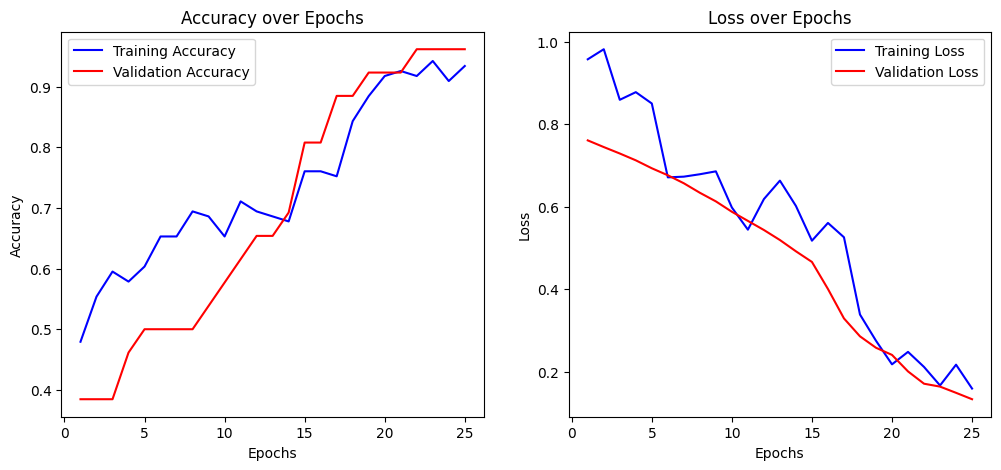

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# تحويل النتائج من tf.Tensor إلى numpy (إذا لزم الأمر)
train_acc = np.array(history.history['accuracy'])
val_acc   = np.array(history.history['val_accuracy'])
train_loss = np.array(history.history['loss'])
val_loss   = np.array(history.history['val_loss'])

# إذا كنت تريد دمج Fine-tuning أيضًا
train_acc_ft = np.array(history_fine.history['accuracy'])
val_acc_ft   = np.array(history_fine.history['val_accuracy'])
train_loss_ft = np.array(history_fine.history['loss'])
val_loss_ft   = np.array(history_fine.history['val_loss'])

# دمج الحلقات التدريبية
acc_all = np.concatenate([train_acc, train_acc_ft])
val_acc_all = np.concatenate([val_acc, val_acc_ft])
loss_all = np.concatenate([train_loss, train_loss_ft])
val_loss_all = np.concatenate([val_loss, val_loss_ft])

epochs = range(1, len(acc_all)+1)

# رسم دقة التدريب والتحقق
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc_all, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_all, 'r-', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# رسم خسارة التدريب والتحقق
plt.subplot(1,2,2)
plt.plot(epochs, loss_all, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_all, 'r-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Confusion Matrix:
 [[13  0]
 [ 1 12]]


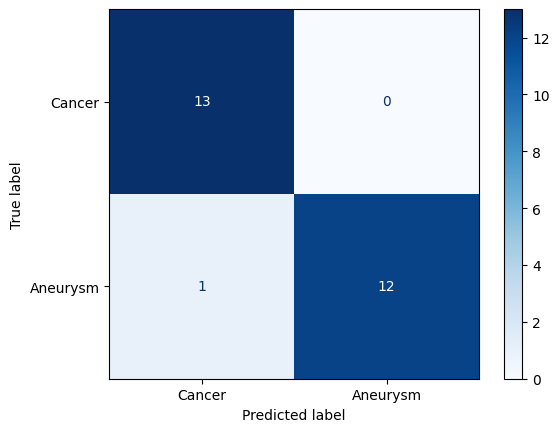

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# predictions
y_pred_prob = model.predict(test_X)
y_pred = (y_pred_prob > 0.5).astype(int)  # threshold 0.5

# confusion matrix
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:\n", cm)

# عرض مصور
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancer', 'Aneurysm'])
disp.plot(cmap='Blues')


In [22]:
H5_PATH = "/content/ct_model.h5"
model.save(H5_PATH)

In [24]:
from tensorflow.keras.models import load_model
loaded_model = load_model(H5_PATH)


In [25]:
test_loss, test_acc = loaded_model.evaluate(test_X, test_y, batch_size=8)
print("Loaded Model Test Accuracy:", test_acc)


4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9763 - loss: 0.2003
Loaded Model Test Accuracy: 0.9615384340286255


In [26]:
import cv2
import numpy as np
import pydicom
import os

IMG_SIZE = (224, 224)

def load_single_image(path):
    if path.endswith('.jpg'):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:  # dcm
        dcm = pydicom.dcmread(path)
        img = dcm.pixel_array.astype(np.float32)
        img = np.clip(img, -100, 400)
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)

    img = cv2.resize(img, IMG_SIZE)
    img = np.stack([img]*3, axis=-1)  # تحويل الرمادي إلى RGB
    img = img / 255.0  # تطبيع
    return np.expand_dims(img, axis=0)  # إضافة بعد batch


In [27]:
image_path = "/content/1_10.jpg"  # ضع مسار الصورة هنا
img = load_single_image(image_path)

prediction = model.predict(img)[0][0]

# التفسير
if prediction >= 0.5:
    print(f"Prediction: Aneurysm ({prediction:.2f})")
else:
    print(f"Prediction: not Aneurysm ({prediction:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Prediction: Aneurysm (0.79)


In [28]:



image_path = "/content/1_11.jpg"
img = load_single_image(image_path)

prediction = model.predict(img)[0][0]

# التفسير
if prediction >= 0.5:
    print(f"Prediction: Aneurysm ({prediction:.2f})")
else:
    print(f"Prediction: not Aneurysm ({prediction:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction: not Aneurysm (0.04)
